In [1]:
import numpy as np
import math
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import cartopy
import cartopy.crs as ccrs
import metpy.calc as mpcalc
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
import pop_tools 
import matplotlib.path as mpath
import dask
#import esmlab
import utils
import pandas as pd
import numpy as np
import cmocean

import matplotlib.gridspec as gridspec
import matplotlib.colors as colors

In [2]:
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001/FEISTY'

files = sorted(glob(f'{path}/FEISTY-hi-res-x0.1-????.nc'))
        
ds=xr.open_mfdataset(files,concat_dim="time", coords='minimal', compat="override", combine='nested')

In [3]:
ds['time'] = np.arange(1980,2022)

### Let's trim to 1990 to 2005

In [4]:
ds['time'].isel(time=slice(10,26))

<xarray.DataArray 'time' (time: 16)>
array([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005])
Coordinates:
  * time     (time) int64 1990 1991 1992 1993 1994 ... 2001 2002 2003 2004 2005

In [5]:
ds = ds.isel(time=slice(10,26))

### Spin up a Dask cluster

In [6]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='20GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=20GB',
        project='NCGD0011',
        walltime='06:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [7]:
cluster, client = get_ClusterClient()
cluster.scale(24) 

In [8]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.83:41763,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Input data

In [9]:
# %%time
# ### first do 1958
# year=1980

# yr4="{:04d}".format(year)
# path = '/glade/scratch/kristenk/feisty_output/hi-res/hist/highres.' + yr4 + '.zarr'

# ds_tmp = xr.open_zarr(path, consolidated=False)

# ds = ds_tmp.mean(dim='time') #.resample({'time':'M'}).mean(dim='time').compute()

# ### then do the rest of the years

# for year in np.arange(1981,1991,1):
#     print(year)
#     yr4="{:04d}".format(year)
#     path = '/glade/scratch/kristenk/feisty_output/hi-res/hist/highres.' + yr4 + '.zarr'
    
#     ds_tmp = xr.open_zarr(path, consolidated=False)
    
#     #ds_mon = ds_tmp.resample({'time':'M'}).mean(dim='time').compute()
#     ds_tmp = ds_tmp.mean(dim='time')
#     ds = xr.concat([ds, ds_tmp], "time")

In [10]:
ds

<xarray.Dataset>
Dimensions:     (time: 16, group: 9, nlat: 2400, nlon: 3600, fish: 8)
Coordinates:
  * fish        (fish) object 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld'
  * group       (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat        (nlat) int64 0 1 2 3 4 5 6 ... 2394 2395 2396 2397 2398 2399
  * nlon        (nlon) int64 0 1 2 3 4 5 6 ... 3594 3595 3596 3597 3598 3599
  * time        (time) int64 1990 1991 1992 1993 1994 ... 2002 2003 2004 2005
Data variables:
    biomass     (time, group, nlat, nlon) float64 dask.array<chunksize=(1, 9, 2400, 3600), meta=np.ndarray>
    fish_yield  (time, fish, nlat, nlon) float64 dask.array<chunksize=(1, 8, 2400, 3600), meta=np.ndarray>
    production  (time, fish, nlat, nlon) float64 dask.array<chunksize=(1, 8, 2400, 3600), meta=np.ndarray>

In [11]:
ds_mean_fish = ds.mean(dim='time').load()

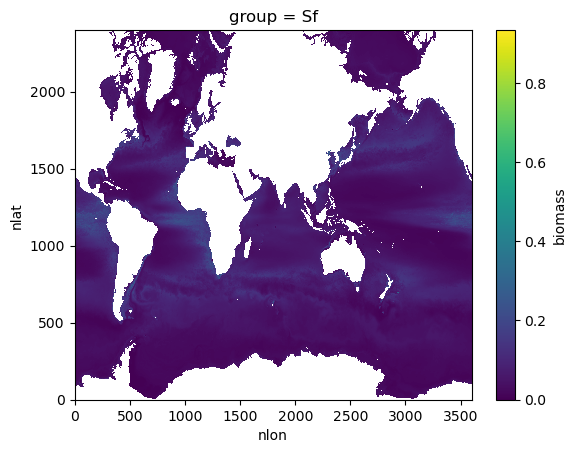

In [12]:
ds_mean_fish.biomass.sel(group='Sf').plot()

In [13]:
ds_grid = pop_tools.get_grid('POP_tx0.1v3')
lons = ds_grid.TLONG
lats = ds_grid.TLAT
area = ds_grid.TAREA

In [14]:
ds_mean_fish

<xarray.Dataset>
Dimensions:     (group: 9, nlat: 2400, nlon: 3600, fish: 8)
Coordinates:
  * fish        (fish) object 'Sf' 'Sp' 'Sd' 'Mf' 'Mp' 'Md' 'Lp' 'Ld'
  * group       (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat        (nlat) int64 0 1 2 3 4 5 6 ... 2394 2395 2396 2397 2398 2399
  * nlon        (nlon) int64 0 1 2 3 4 5 6 ... 3594 3595 3596 3597 3598 3599
Data variables:
    biomass     (group, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    fish_yield  (fish, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    production  (fish, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan

In [15]:
tot_forage = ds_mean_fish.biomass.sel(group='Sf') + ds_mean_fish.biomass.sel(group='Mf')
tot_pelagic = ds_mean_fish.biomass.sel(group='Sp') + ds_mean_fish.biomass.sel(group='Mp') + ds_mean_fish.biomass.sel(group='Lp')
tot_demersal = ds_mean_fish.biomass.sel(group='Sd') + ds_mean_fish.biomass.sel(group='Md') + ds_mean_fish.biomass.sel(group='Ld')

tot_fish = tot_forage + tot_pelagic + tot_demersal

### Annual mean fish biomass maps

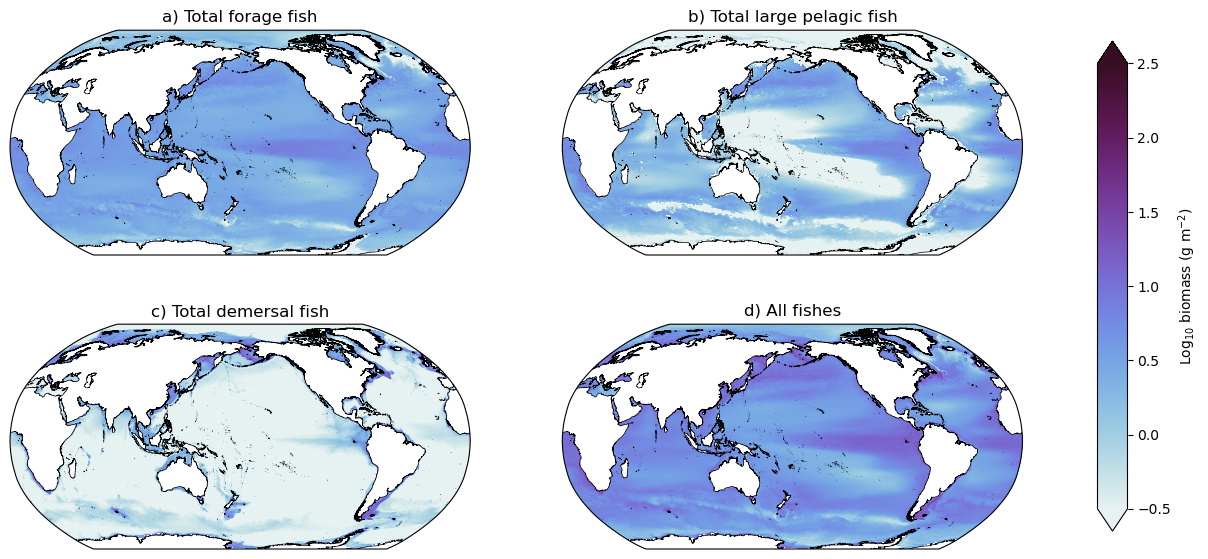

In [16]:
fig = plt.figure(figsize=(15,7))

tot_fish_group_label_dict = {'forage':
                             {'data': tot_forage,
                              'label': "a) Total forage fish"},
                             'pelagic':
                             {'data': tot_pelagic,
                              'label': "b) Total large pelagic fish"},
                             'demersal':
                             {'data': tot_demersal,
                              'label': "c) Total demersal fish"},
                             'total':
                             {'data': tot_fish,
                              'label': "d) All fishes"}
                            }

plot_index = 1

for i in tot_fish_group_label_dict.keys():
    ax = fig.add_subplot(2,2,plot_index, projection=ccrs.Robinson(central_longitude=180))
    plot_index += 1

    ax.set_title(tot_fish_group_label_dict[i]['label'], loc='center')
    lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish_group_label_dict[i]['data'])) 

    pc=ax.pcolormesh(lon, lat, field, 
                     vmin=-0.5, vmax=2.5, 
                     cmap=cmocean.cm.dense,
                     transform=ccrs.PlateCarree())

    ax.coastlines('10m',linewidth=0.5)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar1 = fig.colorbar(pc, cax=cbar_ax,extend='both',label='Log$_{10}$ biomass (g m$^{-2}$)')

fig.savefig('/glade/work/kristenk/figs/fig_fish_mean_maps_hires.png', bbox_inches='tight', dpi=300, format='png');


### Now read in phyto and zoo data, then make dominant type maps and zonal mean plots

In [17]:
ocn_vars = ['spC','diatC','diazC','coccoC','mesozooC','microzooC']
case = 'g.e22.TL319_t13.G1850ECOIAF_JRA_HR.4p2z.001'
path = '/glade/campaign/cgd/oce/projects/FOSI_BGC/HR/' + case + '/ocn/proc/tseries/month_1'

In [18]:
def preprocess(ds):
    #ds=ds.isel(z_t=0)
    ds=ds.mean(dim=['time']).compute()
    ds = ds.sum(dim='z_t_150m').compute() #.where(ds_grid.REGION_MASK>0).compute()
    return ds

In [19]:
keep_vars = ocn_vars +['dz','KMT']

In [20]:
%%time

ds_ann_fosi = xr.Dataset()

#for year in np.arange(1997,2006,1):
for year in np.arange(1990,2006,1):
    yr4="{:04d}".format(year)
    ds = xr.Dataset()
    print(year)
    for v in ocn_vars:  
        print(v)
        files = sorted(glob(f'{path}/{case}.pop.h.{v}.{yr4}01-{yr4}12.nc'))
        
        dsv=xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], combine='nested',decode_times=True,preprocess=preprocess)

        ds = xr.merge((ds, dsv))

    ds = ds.drop([v for v in ds.variables if v not in keep_vars]).squeeze()
    
    ## add it to the annual file
    ds_ann_fosi = xr.concat([ds_ann_fosi, ds], "time")

1990
spC
diatC
diazC
coccoC
mesozooC
microzooC
1991
spC
diatC
diazC
coccoC
mesozooC
microzooC
1992
spC
diatC
diazC
coccoC
mesozooC
microzooC
1993
spC
diatC
diazC
coccoC
mesozooC
microzooC
1994
spC
diatC
diazC
coccoC
mesozooC
microzooC
1995
spC
diatC
diazC
coccoC
mesozooC
microzooC
1996
spC
diatC
diazC
coccoC
mesozooC
microzooC
1997
spC
diatC
diazC
coccoC
mesozooC
microzooC
1998
spC
diatC
diazC
coccoC
mesozooC
microzooC
1999
spC
diatC
diazC
coccoC
mesozooC
microzooC
2000
spC
diatC
diazC
coccoC
mesozooC
microzooC
2001
spC
diatC
diazC
coccoC
mesozooC
microzooC
2002
spC
diatC
diazC
coccoC
mesozooC
microzooC
2003
spC
diatC
diazC
coccoC
mesozooC
microzooC
2004
spC
diatC
diazC
coccoC
mesozooC
microzooC
2005
spC
diatC
diazC
coccoC
mesozooC
microzooC
CPU times: user 4min 3s, sys: 3min 27s, total: 7min 30s
Wall time: 1h 6min 44s


In [21]:
ds_ann_fosi = ds_ann_fosi.where(ds_grid.REGION_MASK>0).compute()

#### now for each variable, take times 10 to make a proper depth integral and adjust attributes

In [22]:
for var in ocn_vars:
    
    ds[var] = ds[var] * 10.
    ds[var].attrs['units'] = 'mmol/m2'

In [23]:
for var in ocn_vars:
    
    ds[var] = ds[var] * 0.001 * 12.
    ds[var].attrs['units'] = 'g/m2'

In [24]:
ds_fosi_mean = ds_ann_fosi.mean(dim='time').load()

#### calc dominant phyto

In [25]:
tot_phyto = ds_fosi_mean.spC + ds_fosi_mean.diatC + ds_fosi_mean.coccoC + ds_fosi_mean.diazC

sp_frac = ds_fosi_mean.spC/tot_phyto
diat_frac =  ds_fosi_mean.diatC/tot_phyto
cocco_frac = ds_fosi_mean.coccoC/tot_phyto
diaz_frac = ds_fosi_mean.diazC/tot_phyto

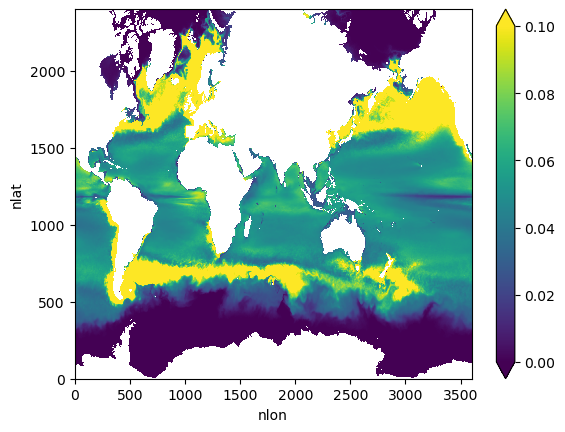

In [26]:
cocco_frac.plot(vmin=0,vmax=0.1)

In [27]:
tmp = xr.concat((sp_frac, diat_frac, cocco_frac, diaz_frac),dim='phyto')
dom_phyto = tmp.argmax(dim='phyto', skipna=False).where(ds_grid.REGION_MASK >0)

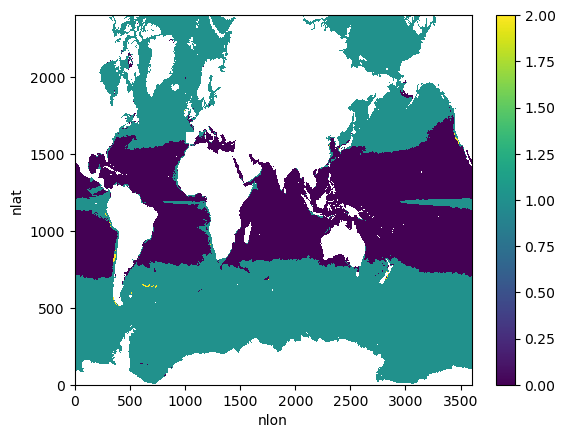

In [28]:
dom_phyto.plot()

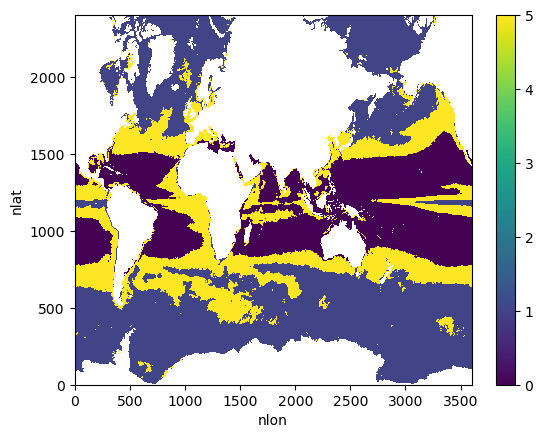

In [29]:
max_fracs = tmp.max(dim='phyto', skipna=False).where(ds_grid.REGION_MASK >0)
dom_phyto.where(max_fracs>0.6,other=5).where(ds_grid.REGION_MASK > 0).plot()

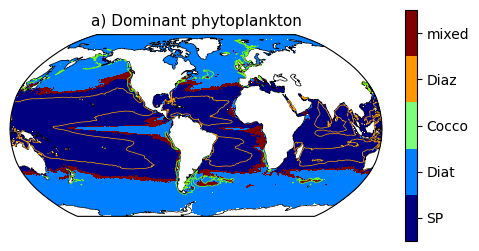

In [30]:
fig = plt.figure(figsize=(6,3))

##############

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
colorbar_specs = {'ticks' : np.arange(0,5,1)}
ax.set_title('a) Dominant phytoplankton', fontsize=11)

lon, lat, field = utils.adjust_pop_grid(lons, lats,  dom_phyto.where(max_fracs>0.5,other=4).where(ds_grid.REGION_MASK > 0))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('jet',5),vmin=-0.5,vmax=4.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon,lat,field = utils.adjust_pop_grid(lons, lats, cocco_frac)
cs = ax.contour(lon,lat,field, colors='lawngreen',
    levels = [0.2],
    linewidths = 0.5,
    transform=ccrs.PlateCarree())


lon,lat,field = utils.adjust_pop_grid(lons, lats, diaz_frac)
cs = ax.contour(lon,lat,field, colors='orange',
    levels = [0.05],
    linewidths = 0.5,
    transform=ccrs.PlateCarree())

cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['SP', 'Diat', 'Cocco', 'Diaz','mixed']);



### calc dominant zoo

In [31]:
microzoo_frac = ds_fosi_mean.microzooC/(ds_fosi_mean.microzooC + ds_fosi_mean.mesozooC)
mesozoo_frac =  ds_fosi_mean.mesozooC/(ds_fosi_mean.microzooC + ds_fosi_mean.mesozooC)

In [32]:
### combine fractions into one dimension
tmp = xr.concat((microzoo_frac, mesozoo_frac),dim='zoo')

max_fracs_zoo = tmp.max(dim='zoo', skipna=False).where(ds_grid.REGION_MASK >0)
dom_zoo = tmp.argmax(dim='zoo', skipna=False).where(ds_grid.REGION_MASK >0)

### calc dominant fish

In [33]:
# forage_frac = tot_forage/tot_fish
# dem_frac = tot_demersal/tot_fish
# pel_frac = tot_pelagic/tot_fish
# for_dem_frac = (tot_forage + tot_demersal)/tot_fish

# pel_frac = pel_frac.drop(['group'])

# ### combine fractions into one dimension
# tmp = xr.concat((forage_frac, dem_frac, pel_frac),dim='fish')

# max_fracs_fish = tmp.max(dim='fish', skipna=False).where(ds_grid.REGION_MASK >0)
# dom_fish = tmp.argmax(dim='fish', skipna=False).where(ds_grid.REGION_MASK >0)

# dom_fish.where(max_fracs_fish>0.6,other=3).plot()

In [34]:
all_year_categories = xr.Dataset()

tot_forage = ds_mean_fish.biomass.sel(group='Sf') + ds_mean_fish.biomass.sel(group='Mf')
tot_pelagic = ds_mean_fish.biomass.sel(group='Sp') + ds_mean_fish.biomass.sel(group='Mp') + ds_mean_fish.biomass.sel(group='Lp')
tot_demersal = ds_mean_fish.biomass.sel(group='Sd') + ds_mean_fish.biomass.sel(group='Md')+ ds_mean_fish.biomass.sel(group='Ld')
tot_fish = tot_forage + tot_pelagic + tot_demersal

all_year_categories["tot_forage"] = tot_forage
all_year_categories["tot_pelagic"] = tot_pelagic
all_year_categories["tot_demersal"] = tot_demersal
all_year_categories["tot_fish"] = tot_fish

all_year_categories = all_year_categories.drop_vars("group")

In [35]:
all_year_categories["mixed"] = xr.where(np.logical_and(
    all_year_categories.tot_forage/all_year_categories.tot_fish<0.5,
    np.logical_and(
    all_year_categories.tot_pelagic/all_year_categories.tot_fish<0.5,
    all_year_categories.tot_demersal/all_year_categories.tot_fish<0.5)), 1, 0)

all_year_categories["f_dom"] = xr.where(np.logical_and(
    all_year_categories.mixed == 0, 
    all_year_categories.tot_forage/all_year_categories.tot_fish>=0.5), 2, 0)    

all_year_categories["d_dom"] = xr.where(np.logical_and(
    all_year_categories.mixed == 0, 
    all_year_categories.tot_demersal/all_year_categories.tot_fish>=0.5), 3, 0)  

all_year_categories["p_dom"] = xr.where(np.logical_and(
    all_year_categories.mixed == 0, 
    all_year_categories.tot_pelagic/all_year_categories.tot_fish>=0.5), 4, 0) 

all_year_categories["pf_dom"] = xr.where(np.logical_and(
    all_year_categories.mixed == 1,
    all_year_categories.tot_demersal/all_year_categories.tot_fish<0.2), 1, 0)

all_year_categories["df_dom"] = xr.where(np.logical_and(
    all_year_categories.mixed == 1, 
    all_year_categories.tot_pelagic/all_year_categories.tot_fish<0.2), 1, 0)

all_year_categories["dom_categories"] = (all_year_categories.f_dom + all_year_categories.mixed + 
                                         all_year_categories.d_dom + all_year_categories.p_dom)


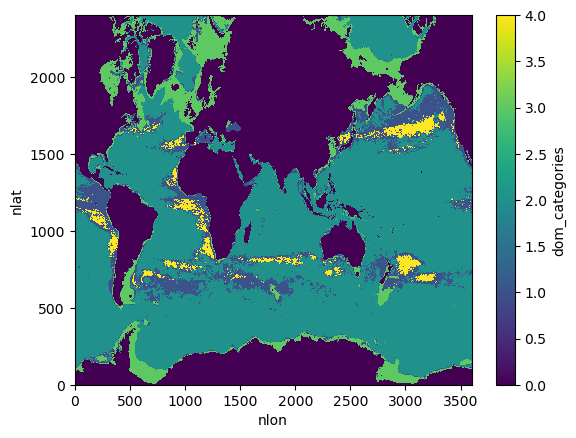

In [36]:
all_year_categories["dom_categories"].plot()

### Make right side of the figure - dominance maps

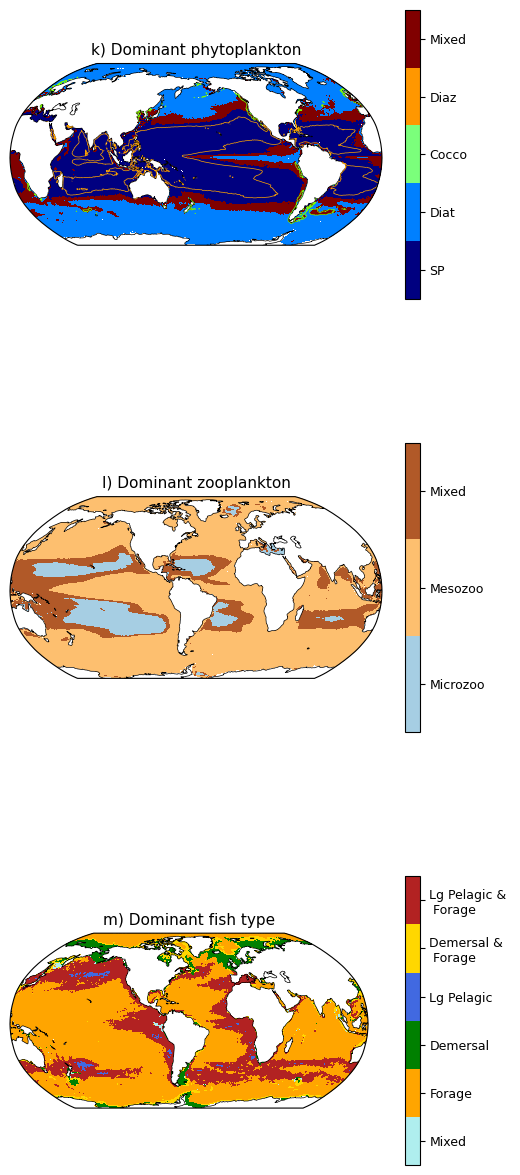

In [41]:
fig = plt.figure(figsize=(6,15))

##############
ax = fig.add_subplot(3,1,1, projection=ccrs.Robinson(central_longitude=180))
colorbar_specs = {'ticks' : np.arange(0,5,1)}
ax.set_title('k) Dominant phytoplankton', fontsize=11)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dom_phyto.where(max_fracs>0.55,other=4).where(ds_grid.REGION_MASK > 0))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('jet',5),vmin=-0.5,vmax=4.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

lon,lat,field = utils.adjust_pop_grid(lons, lats, cocco_frac)
cs = ax.contour(lon,lat,field, colors='lawngreen',
    levels = [0.25],
    linewidths = 0.5,
    transform=ccrs.PlateCarree())


lon,lat,field = utils.adjust_pop_grid(lons, lats, diaz_frac)
cs = ax.contour(lon,lat,field, colors='orange',
    levels = [0.05],
    linewidths = 0.5,
    transform=ccrs.PlateCarree())

cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['SP', 'Diat', 'Cocco', 'Diaz','Mixed'], fontsize=9);

ax = fig.add_subplot(3,1,2, projection=ccrs.Robinson(central_longitude=305.0))
colorbar_specs = {'ticks' : np.arange(0,3,1)}
ax.set_title('l) Dominant zooplankton', fontsize=11)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  dom_zoo.where(max_fracs_zoo>0.55,other=2).where(ds_grid.REGION_MASK > 0))
pc=ax.pcolormesh(lon, lat, field, cmap=plt.cm.get_cmap('Paired',3),vmin=-0.5,vmax=2.5,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
cbar = fig.colorbar(pc, ax=ax,**colorbar_specs)
cbar.ax.set_yticklabels(['Microzoo', 'Mesozoo','Mixed'], fontsize=9);

ax = fig.add_subplot(3,1,3, projection=ccrs.Robinson(central_longitude=305.0))
colorbar_specs = {'ticks' : np.arange(0,4,1)}
ax.set_title('m) Dominant fish type', fontsize=11)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  all_year_categories["dom_categories"].where(ds_grid.REGION_MASK > 0))
lon, lat, field2 = utils.adjust_pop_grid(lons, lats, all_year_categories["df_dom"].where(ds_grid.REGION_MASK > 0))
lon, lat, field3 = utils.adjust_pop_grid(lons, lats, all_year_categories["pf_dom"].where(ds_grid.REGION_MASK > 0))

colorlist = ['paleturquoise', 'orange', 'green', 'royalblue', 'gold', 'firebrick']

cmap = matplotlib.colors.LinearSegmentedColormap.from_list('fish_cats', colorlist, N=6)


#ax.add_feature(cartopy.feature.LAND, zorder=3, edgecolor='k', facecolor="white")
pc=ax.pcolormesh(lon, lat, field, cmap=cmap, vmin=0.5, vmax=6.5,
                 transform=ccrs.PlateCarree())

pc1=ax.contourf(lon, lat, field2,levels=[0.5,1.5],transform=ccrs.PlateCarree(),colors=colorlist[4])
pc2=ax.contourf(lon, lat, field3,levels=[0.5,1.5],transform=ccrs.PlateCarree(),colors=colorlist[5])

ax.coastlines('110m',linewidth=0.5)
cbar = fig.colorbar(pc, ax=ax, ticks=[1,2,3,4,5,6], pad=0.08)
cbar.ax.set_yticklabels(['Mixed', 'Forage', 'Demersal', 'Lg Pelagic','Demersal & \n Forage', 'Lg Pelagic & \n Forage'], fontsize=9) 


fig.subplots_adjust(wspace=0.07,hspace=0.5)

fig.savefig('/glade/work/kristenk/figs/dominant_types.png', bbox_inches='tight', dpi=300, format='png');

### Make biomass maps for the left side of the figure

In [45]:
tot_fish_group_label_dict = {'forage':
                             {'data': tot_forage,
                              'label': "a) Total forage fish"},
                             'pelagic':
                             {'data': tot_pelagic,
                              'label': "b) Total large pelagic fish"},
                             'demersal':
                             {'data': tot_demersal,
                              'label': "c) Total demersal fish"},
                             'total':
                             {'data': tot_fish,
                              'label': "d) All fishes"}
                            }


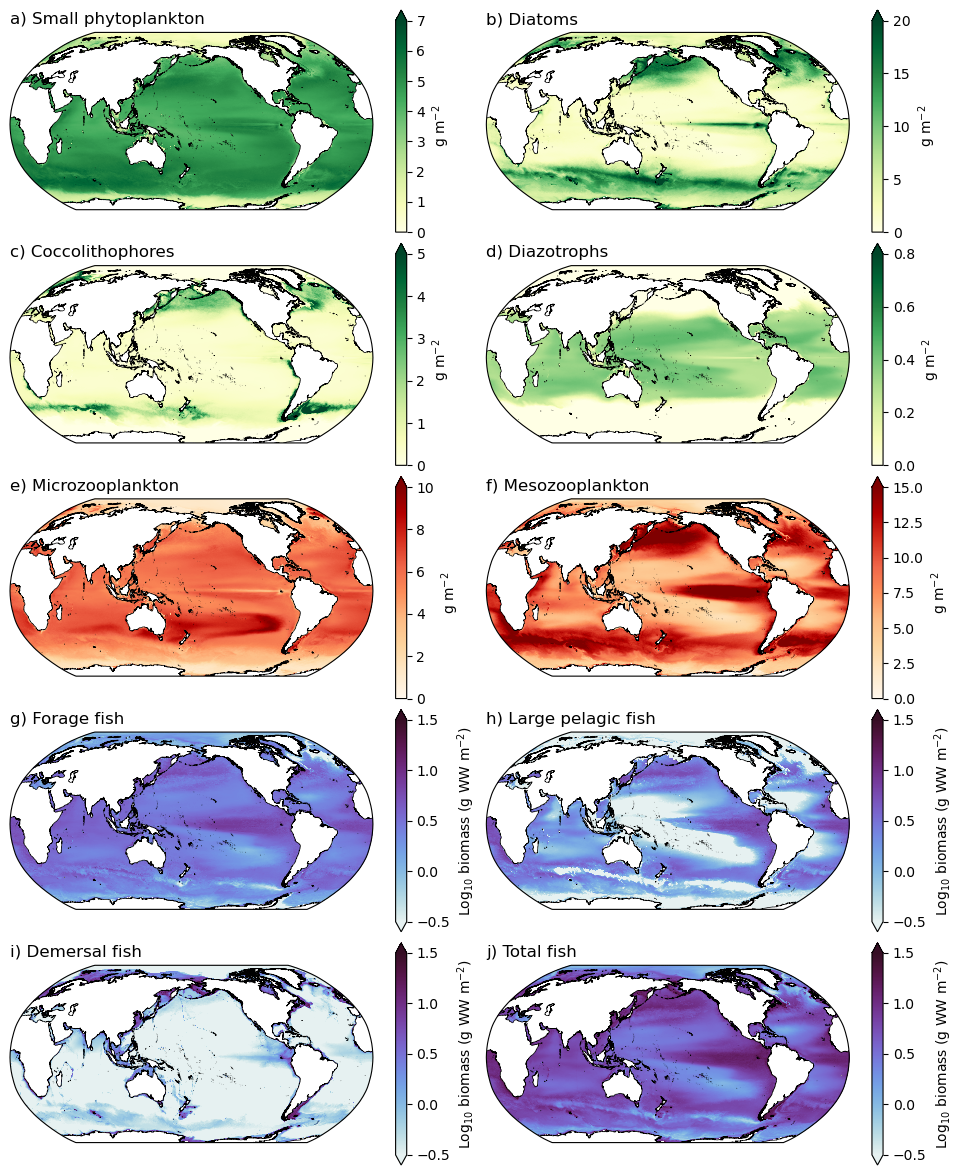

In [46]:
fig = plt.figure(figsize=(12,15))

################# phytoplankton
ax = fig.add_subplot(5,2,1, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('a) Small phytoplankton', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_fosi_mean.spC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=7, 
                 #cmap=cmocean.cm.algae,
                 cmap='YlGn',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

############
ax = fig.add_subplot(5,2,2, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('b) Diatoms', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_fosi_mean.diatC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=20, 
                 #cmap=cmocean.cm.algae,
                 cmap='YlGn',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

############
ax = fig.add_subplot(5,2,3, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('c) Coccolithophores', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_fosi_mean.coccoC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=5, 
                 #cmap=cmocean.cm.algae,
                 cmap='YlGn',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

############
ax = fig.add_subplot(5,2,4, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('d) Diazotrophs', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_fosi_mean.diazC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=0.8, 
                 #cmap=cmocean.cm.algae,
                 cmap='YlGn',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

####################### zooplankton
ax = fig.add_subplot(5,2,5, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('e) Microzooplankton', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_fosi_mean.microzooC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=10, 
                 #cmap=cmocean.cm.amp,
                 cmap='OrRd',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

############
ax = fig.add_subplot(5,2,6, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('f) Mesozooplankton', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_fosi_mean.mesozooC.where(ds_grid.REGION_MASK>0)) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=0, vmax=15, 
                 #cmap=cmocean.cm.amp,
                 cmap='OrRd',
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)

fig.colorbar(pc,extend='max', label='g m$^{-2}$');

####################### fish

ax = fig.add_subplot(5,2,7, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('g) Forage fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish_group_label_dict['forage']['data'])) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Log$_{10}$ biomass (g WW m$^{-2}$)')
###########
ax = fig.add_subplot(5,2,8, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('h) Large pelagic fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish_group_label_dict['pelagic']['data'])) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Log$_{10}$ biomass (g WW m$^{-2}$)')
###########
ax = fig.add_subplot(5,2,9, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('i) Demersal fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish_group_label_dict['demersal']['data'])) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Log$_{10}$ biomass (g WW m$^{-2}$)')
#########
ax = fig.add_subplot(5,2,10, projection=ccrs.Robinson(central_longitude=180))

ax.set_title('j) Total fish', loc='left')
lon, lat, field = utils.adjust_pop_grid(lons, lats, np.log10(tot_fish_group_label_dict['total']['data'])) 

pc=ax.pcolormesh(lon, lat, field, 
                 vmin=-0.5, vmax=1.5, 
                 cmap=cmocean.cm.dense,
                 transform=ccrs.PlateCarree())

ax.coastlines('10m',linewidth=0.5)
cbar1 = fig.colorbar(pc, extend='both',label='Log$_{10}$ biomass (g WW m$^{-2}$)')


fig.subplots_adjust(wspace=0.05, hspace=0.05)

fig.savefig('/glade/work/kristenk/figs/all_biomass_glob_maps.png', bbox_inches='tight', dpi=300, format='png');

### Next steps:

#### 1) download right and left sides of figure
#### 2) put them together using Illustrator

### Zonal means (not part of manuscript)

In [47]:
ds_fosi_mean['nlat'] = ds_grid.nlat
ds_fosi_mean['nlon'] = ds_grid.nlon
area['nlat'] = ds_grid.nlat
area['nlon'] = ds_grid.nlon

In [48]:
ones = np.full((2400,3600),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [49]:
ds_zonal_x01 = xr.Dataset()
ds_zonal_x01_sd = xr.Dataset()

for var in ocn_vars:
    
    da = np.full((57),np.nan)
    da_sd = np.full((57),np.nan)
    
    i=0
    
    for lat_band in np.arange(-78,90,3):
        
        mask = ones.where(lats >= lat_band).where(lats < (lat_band+3))
        masked_area = area.where(mask==1)   

        masked_fosi = ds_fosi_mean[var].where(mask==1)

        weighted_mean_fosi = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
        weighted_st_dev = math.sqrt(((masked_fosi - weighted_mean_fosi)**2 * masked_area).sum(dim=('nlon','nlat'))/(masked_area.sum(dim=('nlon','nlat'))))
    
        da[i] = weighted_mean_fosi.values
        da_sd[i] = weighted_st_dev
        #print(lat_band, weighted_mean_fosi.values)
        i = i + 1
        
    ds_zonal_x01[var] = xr.DataArray(da,dims=('lat'))
    ds_zonal_x01_sd[var] = xr.DataArray(da_sd,dims=('lat'))
        
ds_zonal_x01['lat'] = np.arange(-78,93,3)

In [50]:
ds_zonal_x01_sd['lat'] = np.arange(-78,93,3)

In [51]:
#do forage fish

da = np.full((57),np.nan)
da_sd = np.full((57),np.nan)

i=0
    
for lat_band in np.arange(-78,90,3):

    mask = ones.where(lats >= lat_band).where(lats < (lat_band+3))
    masked_area = area.where(mask==1)   

    masked_fosi = tot_forage.where(mask==1)

    weighted_mean_fosi = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    weighted_st_dev = math.sqrt(((masked_fosi - weighted_mean_fosi)**2 * masked_area).sum(dim=('nlon','nlat'))/(masked_area.sum(dim=('nlon','nlat'))))
    
    da[i] = weighted_mean_fosi.values
    da_sd[i] = weighted_st_dev
    #print(lat_band, weighted_mean_fosi.values)
    i = i + 1
        
ds_zonal_x01['forage_fish'] = xr.DataArray(da,dims=('lat'))
ds_zonal_x01_sd['forage_fish'] = xr.DataArray(da_sd,dims=('lat'))

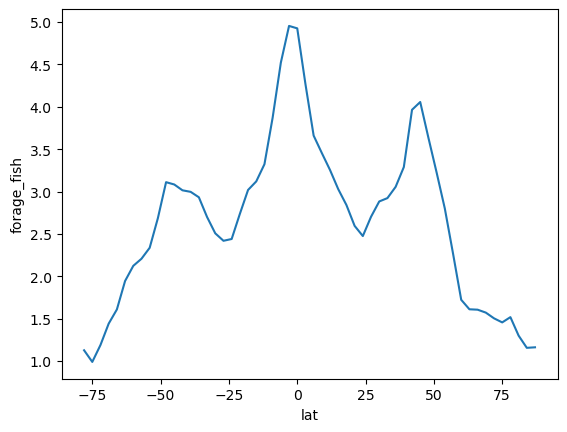

In [52]:
ds_zonal_x01['forage_fish'].plot()

In [53]:
#do pelagic fish

da = np.full((57),np.nan)
da_sd = np.full((57),np.nan)

i=0
    
for lat_band in np.arange(-78,90,3):

    mask = ones.where(lats >= lat_band).where(lats < (lat_band+3))
    masked_area = area.where(mask==1)   

    masked_fosi = tot_pelagic.where(mask==1)

    weighted_mean_fosi = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    weighted_st_dev = math.sqrt(((masked_fosi - weighted_mean_fosi)**2 * masked_area).sum(dim=('nlon','nlat'))/(masked_area.sum(dim=('nlon','nlat'))))
    

    da[i] = weighted_mean_fosi.values
    da_sd[i] = weighted_st_dev
    #print(lat_band, weighted_mean_fosi.values)
    i = i + 1
        
ds_zonal_x01['pelagic_fish'] = xr.DataArray(da,dims=('lat'))
ds_zonal_x01_sd['pelagic_fish'] = xr.DataArray(da_sd,dims=('lat'))

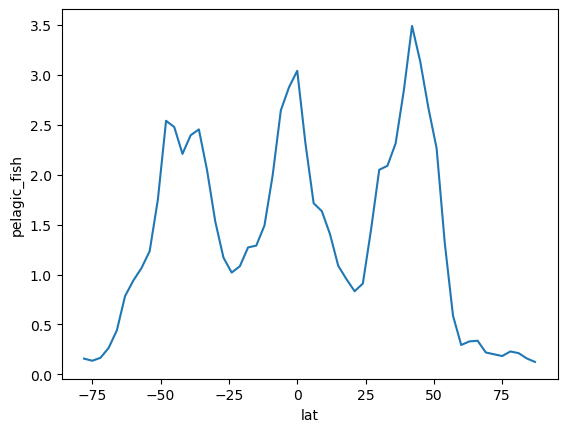

In [54]:
ds_zonal_x01['pelagic_fish'].plot()

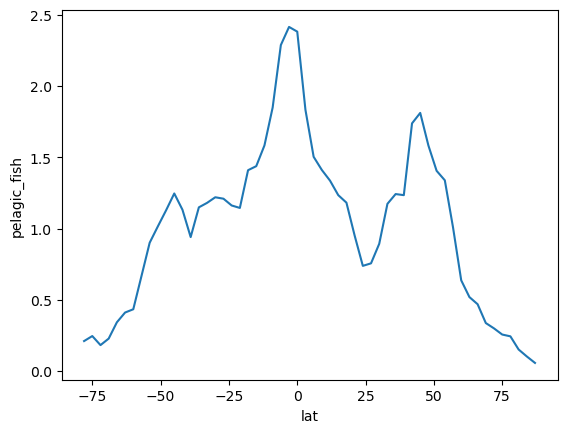

In [55]:
ds_zonal_x01_sd['pelagic_fish'].plot()

In [56]:
tot_demersal = tot_demersal.where(tot_demersal < 10000.)
tot_demersal = tot_demersal.where(tot_demersal > -100.)

In [57]:
#do demersal fish

da = np.full((57),np.nan)
da_sd = np.full((57),np.nan)
    
i=0
    
for lat_band in np.arange(-78,90,3):

    mask = ones.where(lats >= lat_band).where(lats < (lat_band+3))
    masked_area = area.where(mask==1)   

    masked_fosi = tot_demersal.where(mask==1)

    weighted_mean_fosi = (masked_fosi * masked_area).sum(dim=('nlon','nlat')) / masked_area.sum(dim=('nlon','nlat'))
    
    weighted_st_dev = math.sqrt(((masked_fosi - weighted_mean_fosi)**2 * masked_area).sum(dim=('nlon','nlat'))/(masked_area.sum(dim=('nlon','nlat'))))
    
    da[i] = weighted_mean_fosi
    da_sd[i] = weighted_st_dev                                                                            
    #print(lat_band, weighted_mean_fosi.values)
    i = i + 1
        
ds_zonal_x01['demersal_fish'] = xr.DataArray(da,dims=('lat'))
ds_zonal_x01_sd['demersal_fish'] = xr.DataArray(da_sd,dims=('lat'))

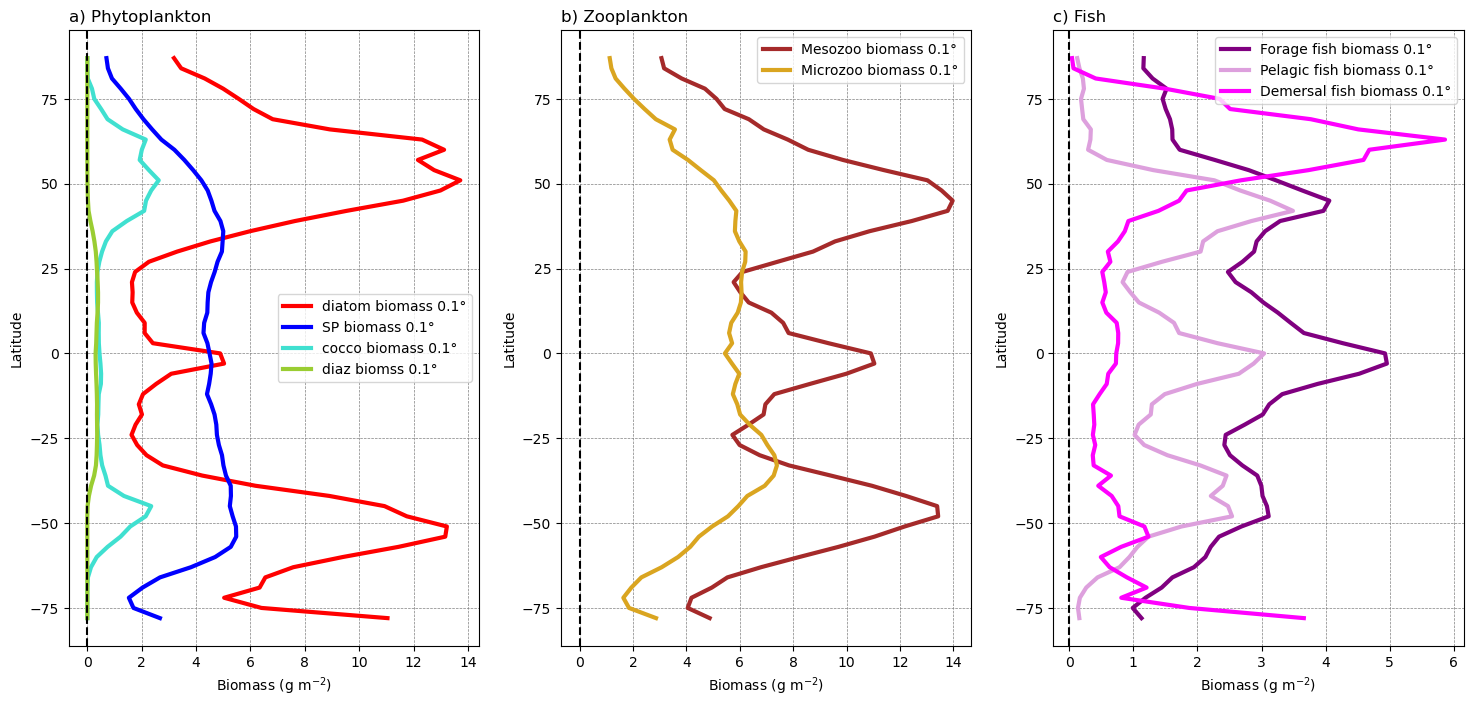

In [58]:
fig = plt.figure(figsize=(18,8))

ax = fig.add_subplot(1,3,1)
ax.set_title('a) Phytoplankton', loc='left')
ax.plot(ds_zonal_x01.diatC, ds_zonal_x01.lat, label='diatom biomass 0.1°', linewidth=3, color='red')
ax.plot(ds_zonal_x01.spC, ds_zonal_x01.lat, label='SP biomass 0.1°', linewidth=3, color='blue')
ax.plot(ds_zonal_x01.coccoC, ds_zonal_x01.lat, label='cocco biomass 0.1°', linewidth=3, color='turquoise')
ax.plot(ds_zonal_x01.diazC, ds_zonal_x01.lat, label='diaz biomss 0.1°', linewidth=3, color='yellowgreen')

# ax.plot(ds_zonal_x1.photoC_diat_zint*0.01*86400, ds_zonal_x1.lat, label='diatom NPP x1', linewidth=1, color='red')
# ax.plot(ds_zonal_x1.photoC_sp_zint*0.01*86400, ds_zonal_x1.lat, label='SP NPP x1', linewidth=1, color='blue')
# ax.plot(ds_zonal_x1.photoC_cocco_zint*0.01*86400, ds_zonal_x1.lat, label='cocco NPP x1', linewidth=1, color='turquoise')
# ax.plot(ds_zonal_x1.photoC_diaz_zint*0.01*86400, ds_zonal_x1.lat, label='diaz NPP x1', linewidth=1, color='yellowgreen')

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')

ax = fig.add_subplot(1,3,2)
ax.set_title('b) Zooplankton', loc='left')
ax.plot(ds_zonal_x01.mesozooC, ds_zonal_x01.lat, label='Mesozoo biomass 0.1°', linewidth=3, color='brown')
ax.plot(ds_zonal_x01.microzooC, ds_zonal_x01.lat, label='Microzoo biomass 0.1°', linewidth=3, color='goldenrod')

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')

ax = fig.add_subplot(1,3,3)
ax.set_title('c) Fish', loc='left')
ax.plot(ds_zonal_x01.forage_fish, ds_zonal_x01.lat, label='Forage fish biomass 0.1°', linewidth=3, color='purple')
ax.plot(ds_zonal_x01.pelagic_fish, ds_zonal_x01.lat, label='Pelagic fish biomass 0.1°', linewidth=3, color='plum')
ax.plot(ds_zonal_x01.demersal_fish, ds_zonal_x01.lat, label='Demersal fish biomass 0.1°', linewidth=3, color='magenta')

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')


fig.savefig('/glade/work/kristenk/figs/zonal_phytozoofish_prod.png', bbox_inches='tight', dpi=300, format='png');

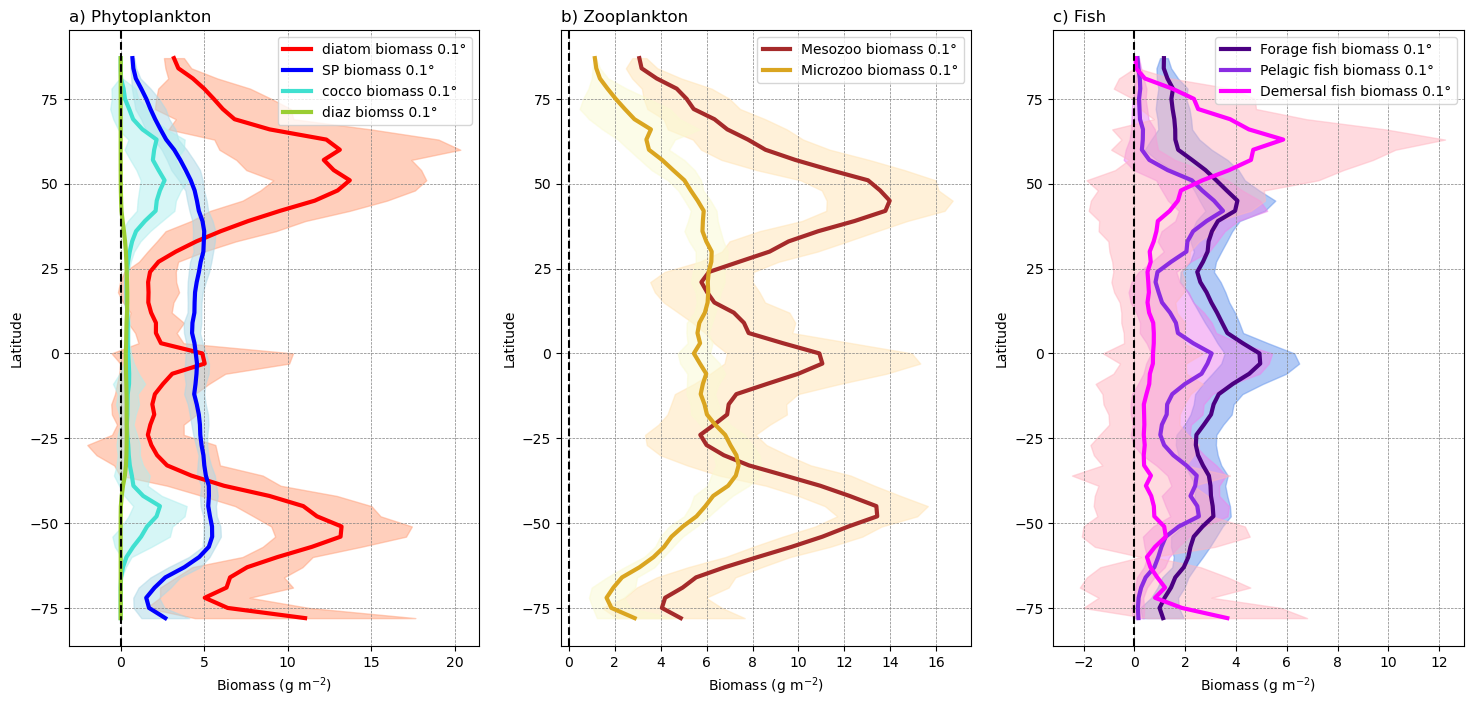

In [59]:
fig = plt.figure(figsize=(18,8))

ax = fig.add_subplot(1,3,1)
ax.set_title('a) Phytoplankton', loc='left')
ax.plot(ds_zonal_x01.diatC, ds_zonal_x01.lat, label='diatom biomass 0.1°', linewidth=3, color='red')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.diatC-ds_zonal_x01_sd.diatC, ds_zonal_x01.diatC+ds_zonal_x01_sd.diatC,
                  color='lightsalmon',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x01.spC, ds_zonal_x01.lat, label='SP biomass 0.1°', linewidth=3, color='blue')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.spC-ds_zonal_x01_sd.spC, ds_zonal_x01.spC+ds_zonal_x01_sd.spC,
                  color='lightblue',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x01.coccoC, ds_zonal_x01.lat, label='cocco biomass 0.1°', linewidth=3, color='turquoise')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.coccoC-ds_zonal_x01_sd.coccoC, ds_zonal_x01.coccoC+ds_zonal_x01_sd.coccoC,
                  color='paleturquoise',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x01.diazC, ds_zonal_x01.lat, label='diaz biomss 0.1°', linewidth=3, color='yellowgreen')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.diazC-ds_zonal_x01_sd.diazC, ds_zonal_x01.diazC+ds_zonal_x01_sd.diazC,
                  color='honeydew',zorder=1,alpha=0.5)

# ax.plot(ds_zonal_x1.photoC_diat_zint*0.01*86400, ds_zonal_x1.lat, label='diatom NPP x1', linewidth=1, color='red')
# ax.plot(ds_zonal_x1.photoC_sp_zint*0.01*86400, ds_zonal_x1.lat, label='SP NPP x1', linewidth=1, color='blue')
# ax.plot(ds_zonal_x1.photoC_cocco_zint*0.01*86400, ds_zonal_x1.lat, label='cocco NPP x1', linewidth=1, color='turquoise')
# ax.plot(ds_zonal_x1.photoC_diaz_zint*0.01*86400, ds_zonal_x1.lat, label='diaz NPP x1', linewidth=1, color='yellowgreen')

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')

ax = fig.add_subplot(1,3,2)
ax.set_title('b) Zooplankton', loc='left')
ax.plot(ds_zonal_x01.mesozooC, ds_zonal_x01.lat, label='Mesozoo biomass 0.1°', linewidth=3, color='brown')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.mesozooC-ds_zonal_x01_sd.mesozooC, ds_zonal_x01.mesozooC+ds_zonal_x01_sd.mesozooC,
                  color='moccasin',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x01.microzooC, ds_zonal_x01.lat, label='Microzoo biomass 0.1°', linewidth=3, color='goldenrod')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.microzooC-ds_zonal_x01_sd.microzooC, ds_zonal_x01.microzooC+ds_zonal_x01_sd.microzooC,
                  color='lightgoldenrodyellow',zorder=1,alpha=0.5)

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')

ax = fig.add_subplot(1,3,3)
ax.set_title('c) Fish', loc='left')
ax.plot(ds_zonal_x01.forage_fish, ds_zonal_x01.lat, label='Forage fish biomass 0.1°', linewidth=3, color='indigo')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.forage_fish-ds_zonal_x01_sd.forage_fish, ds_zonal_x01.forage_fish+ds_zonal_x01_sd.forage_fish,
                  color='cornflowerblue',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x01.pelagic_fish, ds_zonal_x01.lat, label='Pelagic fish biomass 0.1°', linewidth=3, color='blueviolet')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.pelagic_fish-ds_zonal_x01_sd.pelagic_fish, ds_zonal_x01.pelagic_fish+ds_zonal_x01_sd.pelagic_fish,
                  color='violet',zorder=1,alpha=0.5)

ax.plot(ds_zonal_x01.demersal_fish, ds_zonal_x01.lat, label='Demersal fish biomass 0.1°', linewidth=3, color='magenta')
ax.fill_betweenx(ds_zonal_x01.lat, ds_zonal_x01.demersal_fish-ds_zonal_x01_sd.demersal_fish, ds_zonal_x01.demersal_fish+ds_zonal_x01_sd.demersal_fish,
                  color='lightpink',zorder=1,alpha=0.5)

ax.grid(color = 'gray', linestyle = '--', linewidth = 0.5)

ax.legend()
ax.axvline(0, linestyle='--',color='black')
ax.set(ylabel='Latitude',xlabel='Biomass (g m$^{-2}$)')


fig.savefig('/glade/work/kristenk/figs/zonal_phytozoofish_prod.png', bbox_inches='tight', dpi=300, format='png');